# **Regressão por ARIMA**

[Desafio Kaggle YouTube](https://www.kaggle.com/datasnaek/youtube-new)



```
O dataset do Youtube trends possui algumas features interessantes
que variam com o tempo, como a quantidade de visualizações, curtidas, 
não curtidas.

Potencialmente, o seu comportamento pode ser capturado por um modelo 
regressivo e assim, podemos realizar algumas predições sobre a tendência 
da variável.

Utilizaremos o modelo ARIMA para realizar a predição da evolução da 
quantidade de likes de todos os vídeos US da categoria Entretenimento 
nos próximos 10 dias.
```

In [0]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA, ARIMA, AR

from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.stattools import acf

In [0]:
#Lendo o dataset
path = './USvideos.csv'
df = pd.read_csv(path)

In [0]:
#Apresentando informações do dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40949 entries, 0 to 40948
Data columns (total 16 columns):
video_id                  40949 non-null object
trending_date             40949 non-null object
title                     40949 non-null object
channel_title             40949 non-null object
category_id               40949 non-null int64
publish_time              40949 non-null object
tags                      40949 non-null object
views                     40949 non-null int64
likes                     40949 non-null int64
dislikes                  40949 non-null int64
comment_count             40949 non-null int64
thumbnail_link            40949 non-null object
comments_disabled         40949 non-null bool
ratings_disabled          40949 non-null bool
video_error_or_removed    40949 non-null bool
description               40379 non-null object
dtypes: bool(3), int64(5), object(8)
memory usage: 4.2+ MB


In [0]:
# Lendo o arquivo json com a coluna category_id onde os nomes serão vinculados aos iDs em uma nova coluna no dataframe
with open('US_category_id.json', 'r') as f:
  categ_us = json.load(f)

categ_dic = {}
for k in categ_us['items']:
  categ_dic[k['id']]= k['snippet']['title']

temp = df.category_id.copy()
temp = temp.astype('str')
df['category'] = temp.map(categ_dic)

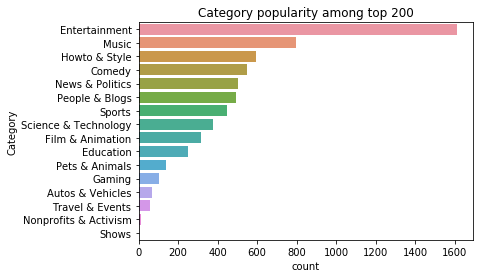

In [0]:
df2 = df.copy()
df2.drop_duplicates('video_id', inplace=True)
sns.countplot(y='category', data=df2, order=df2.category.value_counts().index)
plt.title('Category popularity among top 200')
plt.ylabel('Category')
plt.show();

In [0]:
# Processamento da feature temporal
df.trending_date = pd.to_datetime(df.trending_date, format='%y.%d.%m')

In [0]:
# Vamos remover a coluna "video_error_or_removed" ou outras features que não são interessantes no momento:
df = df.loc[df.video_error_or_removed == False, ]
df = df.loc[df.ratings_disabled == False, ]

In [0]:
# Dataframe contendo evolução temporal da soma de cada feature de todos os videos da categoria escolhida:
category = 'Entertainment'
features = ["views", "likes","dislikes","comment_count", "trending_date"] 

df_total =df[df["category"]==category][features].groupby("trending_date").sum().copy()

df_total.head()

,views,likes,dislikes,comment_count
trending_date,,,,
2017-11-14,28047357,858276,42437,105286
2017-11-15,28235702,905270,45374,113370
2017-11-16,36124139,1178924,44723,132330
2017-11-17,42336053,1330193,53006,151420
2017-11-18,48933568,1484893,52315,154861


In [0]:
# Tratando dias sem registro - Serie será amostrada por dia ("D") e nos dias faltantes iremos preencher com nan 
ts = df_total.likes.asfreq("D", fill_value=np.nan)
ts.isnull().value_counts()

False    205
True       8
Name: likes, dtype: int64

In [0]:
# Dias com registro faltantes
ts[ts.isna()]

trending_date
2018-01-10   NaN
2018-01-11   NaN
2018-04-08   NaN
2018-04-09   NaN
2018-04-10   NaN
2018-04-11   NaN
2018-04-12   NaN
2018-04-13   NaN
Name: likes, dtype: float64

In [0]:
# Substitui valores faltantes pela média dos valores do dia anterior e seguinte não nan
val1 = ts['2018-01-09']
val2 = ts['2018-01-12']
val = (val1 + val2)/2
print(val1, val2, val)

ts['2018-01-10':'2018-01-11'] = val 

val3 = ts['2018-04-07']
val4 = ts['2018-04-14']
val = (val3 + val4)/2
print(val3, val4, val)

ts['2018-04-08':'2018-04-13'] = val

2381810.0 940231.0 1661020.5
3434793.0 3532527.0 3483660.0


In [0]:
df_total.likes = ts

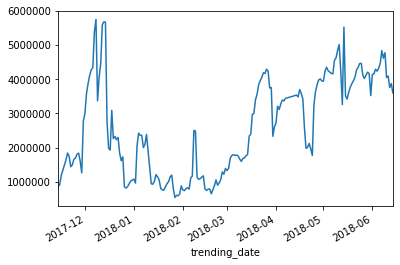

In [0]:
# Verificando a evolução temporal do total de "likes" na categoria Entretenimento
df_total.likes.plot()
plt.show()

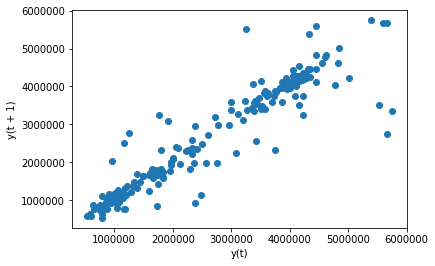

In [0]:
# Verificando se há correlação na série no instante com anterior
pd.plotting.lag_plot(df_total.likes)
plt.show()

In [0]:
# Matriz de autocorrelação com lag 1
values = df_total.likes
dataframe = pd.concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
result = dataframe.corr()
print(result)

          t-1       t+1
t-1  1.000000  0.935339
t+1  0.935339  1.000000


O valor alto na diagonal secundária da matriz de autocorrelação indica uma alta correlação entre os instantes atrasados da série. Potencialmente, podemos criar um modelo ARMA para predição.

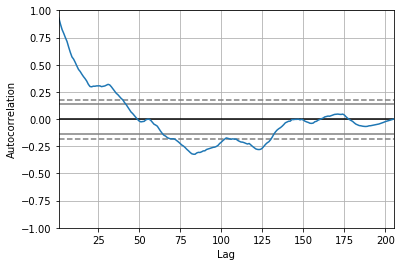

In [0]:
# Verificar a autocorrelação para lags maiores, linha tracejada 99%, cheia 95% são os intervalos de confiança, valores de lag acima da linha apresentam significância 

series = df_total.likes/df_total.likes.std()
pd.plotting.autocorrelation_plot(series)
plt.show()

#plt.xlim((0, 70))

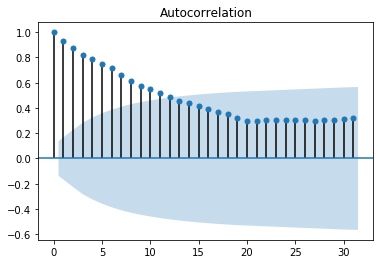

In [0]:
# Verificar a autocorrelação para lags maiores
plot_acf(series, lags=31)
plt.show()

In [0]:
# Testando a hipótese de estacionariedade
result = adfuller(df_total.likes.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -2.694939
p-value: 0.074918


Verificamos se a série está estacionária usando o teste Augmented Dickey Fuller (adfuller()). O valor p-value foi um pouco acima de 0.05 indicando que a série é quase estacionária.

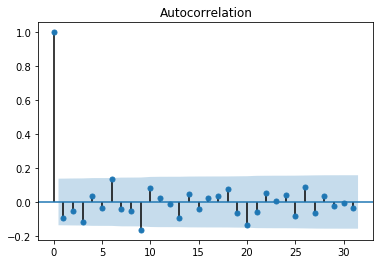

In [0]:
# Aplicando diferenciação para torná-la estacionária
plot_acf(series.diff().dropna(), lags=31)
plt.show()

Aparentemente uma diferenciação é excessiva, pois lag 1 foi rapidamente para < 0 ...

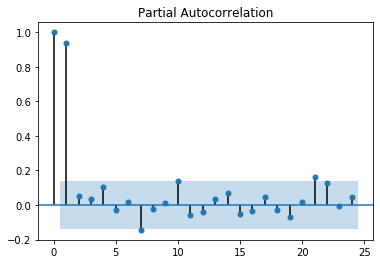

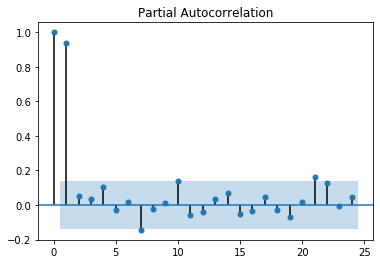

In [0]:
# Encontrando o termo AR (p) 
plot_pacf(series.dropna())

Observando o decaimento da função de autocorrelação (acf) e da parcial (pacf), temos:

* Primeira diferenciação parece excessiva, logo d=0
* 1 termo AR parece suficiente, p=1 
* 1 termo MA parece suficiente, q=1


In [0]:
# Construção do modelo
model = ARIMA(series.values, order=(1,0,0)) #(p, d, q)
model_fit = model.fit(disp=0)
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  205
Model:                     ARMA(1, 0)   Log Likelihood                 -78.460
Method:                       css-mle   S.D. of innovations              0.353
Date:                Wed, 11 Dec 2019   AIC                            162.919
Time:                        22:53:25   BIC                            172.888
Sample:                             0   HQIC                           166.952
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7872      0.357      5.010      0.000       1.088       2.486
ar.L1.y        0.9353      0.024     39.017      0.000       0.888       0.982
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0692           +0.0000j            1.0692            0.0000
-----------------------------------------------------------------------------
"""

Outras combinações de (p, d, q) levaram a coeficientes com relevância baixa (P>|z| >> 0.05).

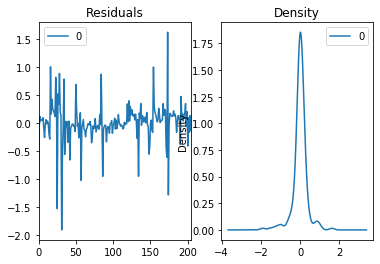

In [0]:
# Plot erro residual
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

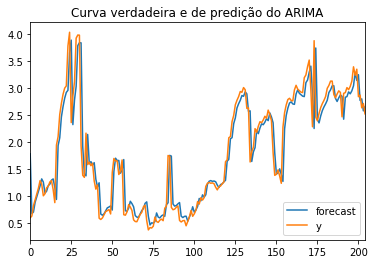

In [0]:
# Atual vs Previsto
model_fit.plot_predict(dynamic=False)
plt.title("Curva verdadeira e de predição do ARIMA")
plt.show()


**Validação cruzada out-time**

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  195
Model:                     ARMA(1, 0)   Log Likelihood               -2840.547
Method:                       css-mle   S.D. of innovations         510282.103
Date:                Wed, 11 Dec 2019   AIC                           5687.095
Time:                        22:53:34   BIC                           5696.914
Sample:                             0   HQIC                          5691.071
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.503e+06   5.12e+05      4.884      0.000     1.5e+06    3.51e+06
ar.L1.y        0.9333      0.025     36.859      0.000       0.884       0.983
                                    Roots           

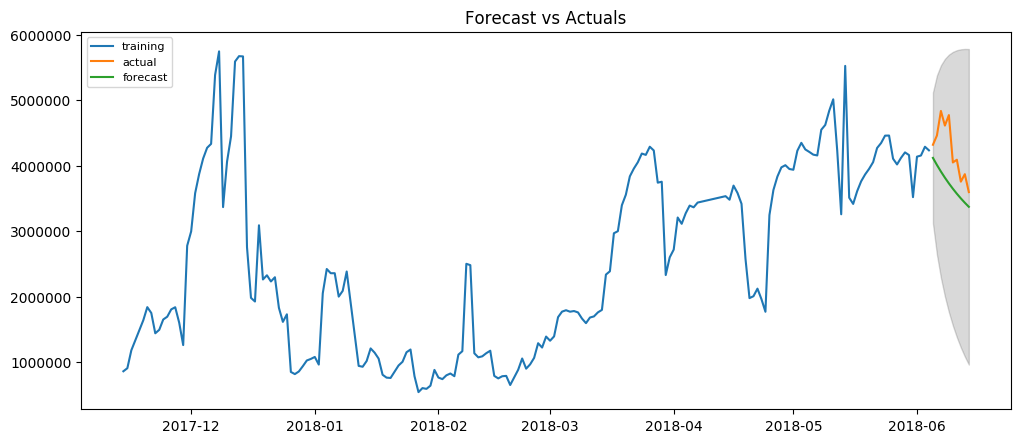

In [0]:
# Cria Training and Test set
train = df_total.likes[:195]
test = df_total.likes[195:]

# Cria Modelo
model = ARIMA(train.values, order=(1, 0, 0))  
fitted = model.fit(disp=0) 
print(fitted.summary()) 

# Previsao
fc, se, conf = fitted.forecast(10, alpha=0.05)  # 95% conf

# Cria como um pandas dataframe
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plota
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [0]:
# Metricas
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fc, test.values)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


{'acf1': 0.2893012405063469,
 'corr': 0.7406130263953068,
 'mae': 525152.2866483311,
 'mape': 0.11994714254236376,
 'me': -525152.2866483311,
 'minmax': 0.11994714254236383,
 'mpe': -0.11994714254236376,
 'rmse': 596391.4443570704}

Os resultados obtidos para previsão de 10 dias da evolução da quantidade de likes de todos os vídeos da categoria Entretenimento foram bem satisfatórias.

O valor predito ficou dentro da faixa de intervalo de confiança de **95%** (**região cinza**).

Algumas métricas devem ser analisadas com cautela (MAE, ME e RMSE), pois são altas mas isso não significa que o modelo é ruim, é que o range da nossa série é alta variando de (500 mil a 5.7 milhões).

Por exemplo, MAPE = 0.11, indica que o modelo foi preciso em 89% na janela de 10 dias.